In [1]:
from utils import load_data, check_gpu, check_dir
from clean_session import preprocess_sessions
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
from functools import partial
import matplotlib.pyplot as plt
from clean_session import preprocess_sessions
from create_model_inputs import prepare_data, compute_session_fts, create_model_inputs
import datetime
%matplotlib inline
%load_ext autoreload
%autoreload 2
def fprint(df, name):
    print(f'{name} shape: ({df.shape[0]:,}, {df.shape[1]})')
import pprint
pp = pprint.PrettyPrinter(indent=1)

In [2]:
train = load_data('train')

In [3]:
train.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [4]:
train['cf'] = train['current_filters'].str.split('|')

In [7]:
train.dropna(subset=['cf'], inplace=True)

In [8]:
cfs = np.concatenate(train.cf.values)

In [14]:
cfs_ctn = pd.value_counts(cfs, normalize=True)*100

In [20]:
cfs_ctn.cumsum()[:32]

Hotel                              11.022498
5 Star                             19.724322
Resort                             27.998081
4 Star                             35.927706
Sort by Price                      43.711374
Hostal (ES)                        50.639675
Motel                              57.453457
Focus on Distance                  63.322153
3 Star                             67.957136
Best Value                         71.375954
Free WiFi (Combined)               74.157839
Very Good Rating                   76.621883
Breakfast Included                 78.826212
Excellent Rating                   80.843151
Car Park                           82.654603
Good Rating                        84.390349
Swimming Pool (Combined Filter)    86.116529
House / Apartment                  87.646819
2 Star                             88.962482
Air Conditioning                   90.131883
Serviced Apartment                 91.287026
Sort By Distance                   92.263096
Spa (Welln

In [2]:
nrows = 1000000
train = prepare_data('train', convert_action_type=False, nrows=nrows, recompute=True)
df = compute_session_fts(train, 'train')

[05-17 14:35:34 - utils-106 - load_data - INFO] Loading train using 1,000,000 rows (999,995 trimmed) which is 6.28% out of total train data
[05-17 14:35:34 - create_model_inputs-17 - flogger - INFO] raw train shape: (999,995, 12)
[05-17 14:35:34 - clean_session-60 - preprocess_sessions - INFO] Dropping duplicates
[05-17 14:35:34 - clean_session-18 - remove_duplicates - INFO] Before dropping duplicates df shape: (999,995, 12)
[05-17 14:35:35 - clean_session-21 - remove_duplicates - INFO] After dropping duplicates df shape: (421,117, 12)
[05-17 14:35:35 - clean_session-62 - preprocess_sessions - INFO] Cliping session dataframe up to last click out (if there is clickout)
[05-17 14:36:01 - clean_session-65 - preprocess_sessions - INFO] Filtering out sessions without clickouts, reference, or clickout is nan
[05-17 14:36:01 - clean_session-66 - preprocess_sessions - INFO] train length before filtering no click-out, or nan reference and click-out sessions: 362,672
[05-17 14:36:51 - clean_sess

In [4]:
df = df.groupby('session_id').last().reset_index()
# df['session_id_size'] = np.log(df['session_id_size'])
# df['cfs'] = df['current_filters_last_filters'].str.lower().str.split('|')

# df['prices'] = df['prices'].str.split('|')
# df['prices'] = df['prices'].apply(lambda x: [int(p) for p in x])

# df['time_steps'] = df['prices'].str.len()
# padding_mask = df['time_steps'] < 25
# df.loc[padding_mask, 'prices'] = df.loc[padding_mask, 'prices'].apply(lambda x: np.pad(x, (0, 25-len(x)),
#                                                                                        mode='constant'))
df['imps'] = df['impressions'].str.split('|')
df['imps'] = df['imps'].apply(lambda x: [int(i) for i in x])
# df.loc[padding_mask, 'impressions'] = (df.loc[padding_mask, 'impressions']
#                                          .apply(lambda x: np.pad(x, (0, 25-len(x)),mode='constant')))
df['reference'] = df['reference'].astype(int)
# filter out nan rows with reference_id not in impressions list, since if the true target in test
# is not in the impression list then it would not get evaluated
def assign_target(row):
    ref = row['reference']
    imp = list(row['imps'])
    if ref in imp:
        return imp.index(ref)
    else:
        return np.nan

df['target'] = df.apply(assign_target, axis=1)
# drop the ones whose reference is not in the impression list
df = df[df['target'].notna()].reset_index(drop=True)
df['target'] = df['target'].astype(int)
# def assign_last_ref_id(row, divide=True):
#     ref = row['reference_last_reference_id']
#     # although reference_id got converted to int, but the reference_last_reference_id was calculated
#     # when it was still str value, so here we look up the index in str of impressions
#     imp = [str(i) for i in row['imps']]

#     if pd.isna(ref):
#         return np.nan
#     else:
#         if ref in imp:
#             if divide:
#                 return (imp.index(ref) + 1) / len(imp)
#             else:
#                 return imp.index(ref) + 1
#         else:
#             return np.nan
# assign_last_ref_id_func = partial(assign_last_ref_id, divide=False)
# df['last_ref_ind'] = df.apply(assign_last_ref_id_func, axis=1)

### comapre session with size 1 and the rest

In [5]:
df.head(2)

,session_id,user_id,timestamp,step,action_type,current_filters,reference,impressions,prices,action_id_pair,timestamp_session_duration,timestamp_dwell_time_prior_clickout,session_id_size,imps,target
0,000263df674fa,C2D58CUH9AOT,2018-11-05 20:36:38,5,clickout item,NaN,8249,8249|8250|14378|67361|8284|8257|1955219|8254|6...,74|88|87|72|56|87|244|168|123|50|129|72|151|83...,"(clickout item, 8249)",293.0,236.0,5,"[8249, 8250, 14378, 67361, 8284, 8257, 1955219...",0
1,0002ccee5a980,M2E4246PL9XQ,2018-11-06 10:30:13,3,clickout item,NaN,109489,118737|1305086|4621782|1397441|53118|766713|92...,79|241|96|51|68|99|86|69|71|79|91|67|70|56|82|...,"(interaction item image, 109489)",1.0,1.0,2,"[118737, 1305086, 4621782, 1397441, 53118, 766...",19


In [6]:
ones = df[df['session_id_size']==1].reset_index(drop=True)
multiples = df[df['session_id_size']>1].reset_index(drop=True)

In [7]:
oids = ones['session_id'].unique()
mids = multiples['session_id'].unique()

In [30]:
df[df.session_id=='0000059a39020']

,session_id,user_id,timestamp,step,action_type,current_filters,reference,impressions,prices,action_id_pair,timestamp_session_duration,timestamp_dwell_time_prior_clickout,session_id_size,imps,target


---
### ones

In [8]:
display_cols = ['session_id', 'step', 'action_type', 'current_filters', 'reference', 'timestamp',
                'impressions', 'prices', 'target', 'session_id_size']
raw_display_cols = [c for c in train.columns if c in display_cols]

In [9]:
# pd.options.display.max_colwidth = 100

In [10]:
one_rid = np.random.choice(oids, 1)[0]
print(one_rid)
df[df.session_id==one_rid][display_cols].reset_index(drop=True)

6a67928c1a1cd


,session_id,step,action_type,current_filters,reference,timestamp,impressions,prices,target,session_id_size
0,6a67928c1a1cd,1,clickout item,NaN,2281538,2018-11-04 13:05:41,34885|2571030|41619|1744145|2281538|3810086|82...,44|49|49|40|37|40|46|49|38|35|39|35|47|42|45|4...,4,1


In [11]:
pp.pprint(df[df.session_id==one_rid][display_cols].reset_index(drop=True).to_dict(orient='list'))

{'action_type': ['clickout item'],
 'current_filters': [nan],
 'impressions': ['34885|2571030|41619|1744145|2281538|3810086|8236454|2268398|2268394|1753495|938410|4539774|5835738|2202954|1753283|824436|1753423|2071362|2071336|2718536|2079142|1003643|3871792|2071346|2933086'],
 'prices': ['44|49|49|40|37|40|46|49|38|35|39|35|47|42|45|40|41|30|38|41|35|47|27|26|45'],
 'reference': [2281538],
 'session_id': ['6a67928c1a1cd'],
 'session_id_size': [1],
 'step': [1],
 'target': [4],
 'timestamp': [Timestamp('2018-11-04 13:05:41')]}


In [23]:
# # and the raw
# train[train.session_id==one_rid][raw_display_cols].reset_index(drop=True)

In [24]:
# pp.pprint(train[train.session_id==one_rid][raw_display_cols].reset_index(drop=True).to_dict(orient='list'))

---
### Longer

In [25]:
mid_rid = np.random.choice(mids, 1)[0]
print(mid_rid)
# df[df.session_id==mid_rid][display_cols].reset_index(drop=True)

b9b1153cd6aff


In [26]:
np.sort([int(i) for i in df[df.session_id==mid_rid]['prices'].str.split('|').values[0]])

array([ 36,  60,  65,  70,  79,  81,  83,  94, 104, 108, 118, 119, 119,
       119, 127, 131, 133, 141, 148, 160, 212, 282, 310, 420, 509])

In [27]:
# pp.pprint(df[df.session_id==mid_rid][display_cols].reset_index(drop=True).to_dict(orient='list'))

In [28]:
# the raw
train[train.session_id==mid_rid][raw_display_cols].reset_index(drop=True)

,session_id,timestamp,step,action_type,current_filters,reference,impressions,prices
0,b9b1153cd6aff,2018-11-01 16:08:52,2,interaction item image,NaN,17038,NaN,NaN
1,b9b1153cd6aff,2018-11-01 16:09:09,3,clickout item,NaN,17038,2401930|45583|9943846|150227|5180292|153593|17...,65|70|160|60|104|212|83|509|133|119|81|141|118...
2,b9b1153cd6aff,2018-11-01 16:43:20,5,interaction item image,NaN,2401930,NaN,NaN
3,b9b1153cd6aff,2018-11-01 16:43:42,6,clickout item,NaN,2401930,2401930|45583|9943846|150227|5180292|153593|17...,65|70|160|60|104|212|83|509|133|119|81|141|118...
4,b9b1153cd6aff,2018-11-01 16:50:17,7,clickout item,NaN,45583,2401930|45583|9943846|150227|5180292|153593|17...,65|70|160|60|104|212|83|509|133|119|81|141|118...
5,b9b1153cd6aff,2018-11-01 16:51:58,8,clickout item,NaN,9943846,2401930|45583|9943846|150227|5180292|153593|17...,65|70|160|60|104|212|83|509|133|119|81|141|118...


In [29]:
pp.pprint(train[train.session_id==mid_rid][raw_display_cols].reset_index(drop=True).to_dict(orient='list'))

{'action_type': ['interaction item image',
                 'clickout item',
                 'interaction item image',
                 'clickout item',
                 'clickout item',
                 'clickout item'],
 'current_filters': [nan, nan, nan, nan, nan, nan],
 'impressions': [nan,
                 '2401930|45583|9943846|150227|5180292|153593|17445|10093744|17474|17198|16934|16915|17291|82552|1434428|17256|5523222|17038|17524|17058|17250|17179|5949552|5773240|17315',
                 nan,
                 '2401930|45583|9943846|150227|5180292|153593|17445|10093744|17474|17198|16934|16915|17291|82552|1434428|17256|5523222|17038|17524|17058|17250|17179|5949552|5773240|17315',
                 '2401930|45583|9943846|150227|5180292|153593|17445|10093744|17474|17198|16934|16915|17291|82552|1434428|17256|5523222|17038|17524|17058|17250|17179|5949552|5773240|17315',
                 '2401930|45583|9943846|150227|5180292|153593|17445|10093744|17474|17198|16934|16915|17291|82552|1

In [19]:
# dup_mask = train[[c for c in train.columns if c not in ['timestamp', 'step']]].duplicated(keep=False)
# dup_mask.sum()

In [20]:
# dup_cols = [c for c in train.columns if c not in ['timestamp', 'step']]
# # train[dup_cols].loc[train[dup_cols].shift(-1) != train[dup_cols]]
# train.groupby(dup_cols).apply(lambda x: )

In [21]:
train.shape

(326695, 9)

In [22]:
99508/train.shape[0]

0.3045899080181821

### Look at test set
---

In [ ]:
test = load_data('tedt')

---
### Click-encodings

In [ ]:
from create_model_inputs import click_view_encoding
_ = click_view_encoding(sids=None, fold='testing', m=5)

In [ ]:
cv_enc = pd.read_csv('./cache/foldtesting_clickview_encodings.csv')

In [ ]:
cv_enc.shape

In [ ]:
cv_enc['clicked'].hist(bins=100)

---
### clickouts

In [33]:
%%time
df = load_data('train', usecols=['session_id', 'action_type', 'impressions', 'reference'])

CPU times: user 16.1 s, sys: 1.08 s, total: 17.2 s
Wall time: 17.2 s


In [34]:
df.shape

(15932992, 4)

In [35]:
df = df.drop_duplicates(subset=[c for c in df.columns if c != 'step']).reset_index(drop=True)

In [36]:
df.shape

(4226084, 4)

In [37]:
%%time
# filter away sessions do not have clickout
def filter_away(df):
    return (df.action_type=='clickout item').sum() > 0
fids = df.groupby('session_id').apply(filter_away)

CPU times: user 4min 6s, sys: 1.22 s, total: 4min 7s
Wall time: 4min 7s


In [41]:
df_has = df[df.session_id.isin(fids[fids].index)]

In [42]:
df_has.shape

(3908900, 4)

In [44]:
# number of clickout rows
(df_has.action_type == 'clickout item').sum()

1410178

In [45]:
last_df_has = df_has.groupby('session_id').last().reset_index()

In [46]:
last_df_has.shape

(826842, 4)

In [51]:
# average number of clickout per session
ctns = df_has[df_has.action_type=='clickout item'].groupby('session_id')['session_id'].size()

In [52]:
ctns.head()

session_id
00000510f1adc    1
00003f3b20954    1
000056cd97ce2    1
000066611146f    1
0000be39860d7    2
Name: session_id, dtype: int64

In [49]:
s = df_has.groupby('session_id')['session_id'].size()

In [50]:
s.head()

session_id
00000510f1adc    1
00003f3b20954    1
000056cd97ce2    3
000066611146f    3
0000be39860d7    6
Name: session_id, dtype: int64

In [57]:
# avg_clickout = ctns/s

In [58]:
# avg_clickout.hist(bins=100)

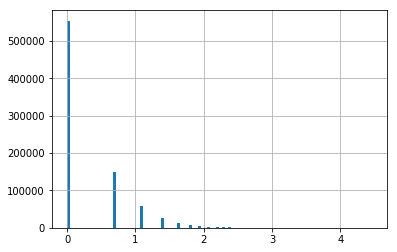

In [63]:
np.log(ctns).hist(bins=100)

In [ ]:
ctn